# INTRODUCTION

* DATASET：https://www.kaggle.com/c/ml100marathon-02-01/data
* GOAL ：Predict the "probability" that a user would use the coupon in 15 days
* Importance：Coupon is an popular promotion way in E-commerce, especially for O2O（Online to Offline) marketing. 
* Column	Description  
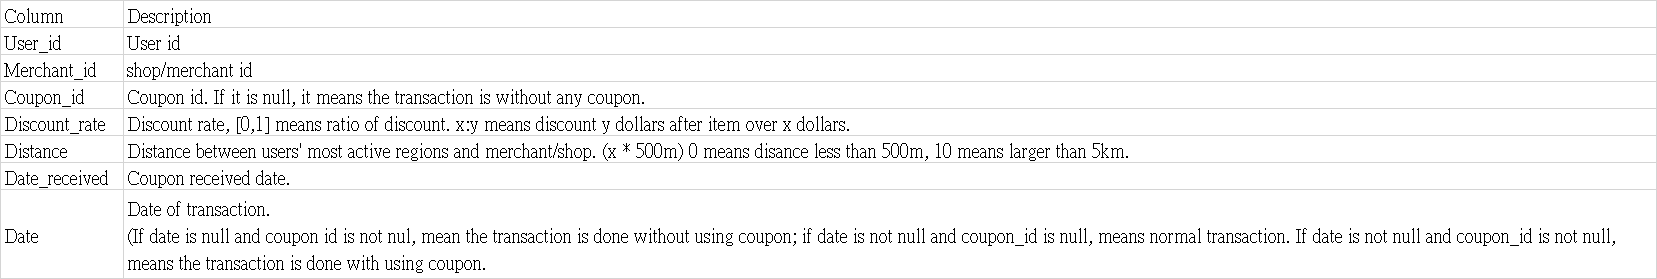


In [3]:
import pandas as pd 
import numpy as np
import datetime

In [199]:
train_offline=pd.read_csv('./train_offline.csv')
test_offline=pd.read_csv('./test_offline.csv')

In [5]:
train_offline.head()

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date
0,1439408,2632,NaN,NaN,0.0,NaN,20160217.0
1,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN
2,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN
3,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN
4,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN


In [6]:
len(train_offline)

1160742

In [200]:
test_offline.head() # Date , label is infact invisible in real data, so can't be treated as features.

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received
0,1439408,4663,11002.0,150:20,1.0,20160528.0
1,1439408,2632,8591.0,20:1,0.0,20160613.0
2,1439408,2632,NaN,NaN,0.0,NaN
3,1439408,2632,8591.0,20:1,0.0,20160516.0
4,2029232,450,1532.0,30:5,0.0,20160530.0


# PREPROCESSING

In [201]:
tr=train_offline.copy()
ts=test_offline.copy()

## Target Label：coupon_use

In [9]:
""" 
-1: Date is not null & Coupon_id is null = do not owns a coupon; 
0 : Date is null & Coupon_id is not null = buy with coupon but out of 15 days
1 : Date is not null & Coupon_id is not null= used a coupon within 15 days
"""
# delete data without coupon , NOT INTERESTED IN
tr=tr[np.isnan(tr['Coupon_id'])==False]
tr.reset_index(inplace=True)
tr=tr.drop(columns='index')

In [203]:
ts=ts[np.isnan(ts['Coupon_id'])==False]
ts.reset_index(inplace=True)
ts=ts.drop(columns='index')

In [10]:
conditions = [
    (np.isnan(tr['Date'])==False),
    (np.isnan(tr['Date'])==True)
    ]
choices = [1,0]
tr['coupon_use'] = np.select(conditions, choices)

In [11]:
tr.head(20)

,User_id,Merchant_id,Coupon_id,Discount_rate,Distance,Date_received,Date,coupon_use
0,1439408,2632,8591.0,20:1,0.0,20160217.0,NaN,0
1,1439408,2632,1078.0,20:1,0.0,20160319.0,NaN,0
2,1832624,3381,7610.0,200:20,0.0,20160429.0,NaN,0
3,2029232,3381,11951.0,200:20,1.0,20160129.0,NaN,0
4,2223968,3381,9776.0,10:5,2.0,20160129.0,NaN,0
5,73611,2099,12034.0,100:10,NaN,20160207.0,NaN,0
6,163606,1569,5054.0,200:30,10.0,20160421.0,NaN,0
7,3273056,4833,7802.0,200:20,10.0,20160130.0,NaN,0
8,94107,3381,7610.0,200:20,2.0,20160412.0,NaN,0
9,253750,8390,7531.0,20:5,0.0,20160327.0,NaN,0


In [12]:
#check data balance
tr['coupon_use'].value_counts()

0    704033
1     42936
Name: coupon_use, dtype: int64

In [13]:
#tr.to_csv('tr_tagged.csv',encoding='utf-8-sig')

In [14]:
tr1=tr.copy()

## 1 Feature Generation

In [15]:
tr1.isnull().any(axis=0)

User_id          False
Merchant_id      False
Coupon_id        False
Discount_rate    False
Distance          True
Date_received    False
Date              True
coupon_use       False
dtype: bool

### (1) Date_received：Time cycle - Day & Weekday + Received size

In [16]:
# Check data time range (It's within 4 month, so no year cycle can be observed.) 
temp=tr1.groupby('Date_received',).size()
temp

Date_received
20160101.0     554
20160102.0     542
20160103.0     536
20160104.0     577
20160105.0     691
              ... 
20160426.0    4579
20160427.0    5565
20160428.0    6104
20160429.0    5634
20160430.0    5008
Length: 121, dtype: int64

In [17]:
print(type(tr1['Date_received'][0]))
print(type(ts['Date_received'][0]))

<class 'numpy.float64'>
<class 'numpy.float64'>


In [18]:
weekcols = ['week_' + str(i) for i in range(1,5)]
weekdaycols = ['Weekday_' + str(i) for i in range(1,8)]
def processDateR(df):
    df['Date_received']=pd.to_datetime(df['Date_received'], format ="%Y%m%d")
    # Day (month cycle
    df['Day']=df['Date_received'].apply(lambda x:x.day) 
    df['Day']=pd.cut(df['Day'], 4,labels=[1,2,3,4]) #label encoding
    tmpdf = pd.get_dummies(df['Day'])
    tmpdf.columns = weekcols
    df[weekcols] = tmpdf    
    del tmpdf    
    # Weekday (week cycle),Let 1==Mon. 7==Sun.
    df['Weekday']=df['Date_received'].apply(lambda x:(x.weekday())+1)
    tmpdf = pd.get_dummies(df['Weekday'])
    tmpdf.columns = weekdaycols
    df[weekdaycols] = tmpdf
    # Weekend
    df['Weekend']=df['Weekday'].apply(lambda x: 1 if x in [6,7] else 0 )

In [19]:
processDateR(tr1)

In [205]:
processDateR(ts)

### (2) Date_Received：Received Size 

In [20]:
tr1.columns

Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date', 'coupon_use', 'Day', 'week_1', 'week_2',
       'week_3', 'week_4', 'Weekday', 'Weekday_1', 'Weekday_2', 'Weekday_3',
       'Weekday_4', 'Weekday_5', 'Weekday_6', 'Weekday_7', 'Weekend'],
      dtype='object')

In [21]:
df=tr1.groupby(['User_id','Date_received']).size().to_frame('received_size')
df.reset_index(inplace=True)
df

,User_id,Date_received,received_size
0,4,2016-02-14,1
1,35,2016-01-29,2
2,35,2016-01-30,2
3,36,2016-01-25,2
4,64,2016-01-29,1
...,...,...,...
545651,7360967,2016-01-10,1
545652,7360967,2016-01-20,1
545653,7360967,2016-03-22,2
545654,7361024,2016-02-11,1


In [22]:
tr1=pd.merge(tr1,df,on=['User_id','Date_received'],how='left')

In [23]:
del df

In [206]:
df=ts.groupby(['User_id','Date_received']).size().to_frame('received_size')
df.reset_index(inplace=True)
ts=pd.merge(ts,df,on=['User_id','Date_received'],how='left')
del df

### (3) Discount_rate： Type, Condition, Price & Rate

In [24]:
#0.95 is much more than <0.9, way of disciunt might be： price*d=Discount_rate= final_price
tr1.groupby('Discount_rate').size() 

Discount_rate
0.2           110
0.5           178
0.6            54
0.7            44
0.75           88
0.8          1734
0.85          633
0.9          7226
0.95        17392
100:1         240
100:10     166693
100:20       5690
100:30      30190
100:5         750
100:50       1114
10:1         7804
10:5        20085
150:10       4946
150:20       4411
150:30        295
150:5           1
150:50         17
200:10        231
200:100         9
200:20     106875
200:30      26864
200:5          38
200:50       4062
20:1        14986
20:10         458
20:5        47990
300:10          5
300:20         12
300:30      28866
300:50         35
30:1         6450
30:10        1872
30:20           8
30:5       172567
50:1         2331
50:10       25544
50:20         652
50:30           9
50:5        36809
5:1           601
dtype: int64

In [25]:
# keep the discount type with a new col (0 for general discount ； 1 for conditional discount  )   
def getDiscountType(row):
    if ':' in row:
        return 1
    else:
        return 0

# Price that meet conditional discount x (x:y means discount y after over "x")
def getConditionPrice(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[0])
    else:
        return 0

# discount price (maybe some didn't calculate "rate")
def getDiscountPrice(row):
    if ':' in row:
        rows = row.split(':')
        return int(rows[1])
    else:
        return 0
    
# convert Discount_rate into Unified format：maximum doscount rate 
def getRate(row):
    if ':' in row:
        rows = row.split(':')
        return 1.0 - float(rows[1])/float(rows[0])
    else:
        return float(row)

In [26]:
def processDiscount(df):
    df['discount_type'] =df['Discount_rate'].astype('str').apply(getDiscountType)
    df['discount_conditionP']=df['Discount_rate'].astype('str').apply(getConditionPrice)  
    df['discount_Price']=df['Discount_rate'].astype('str').apply(getDiscountPrice) 
    df['discount_convRate']=df['Discount_rate'].astype('str').apply(getRate)  
    return df

In [27]:
tr1=processDiscount(tr1)

In [207]:
ts=processDiscount(ts)

In [28]:
#tr1.to_csv('tr_new_features.csv',encoding='utf-8-sig')

## 2 Outlier Detection & Replacement

In [29]:
import pandas as pd
#tr_data=pd.read_csv('./tr_new_features.csv',encoding='utf-8-sig',index_col=0)

In [30]:
#tr2=tr_data.copy()
tr2=tr1.copy()

In [31]:
tr2.columns

Index(['User_id', 'Merchant_id', 'Coupon_id', 'Discount_rate', 'Distance',
       'Date_received', 'Date', 'coupon_use', 'Day', 'week_1', 'week_2',
       'week_3', 'week_4', 'Weekday', 'Weekday_1', 'Weekday_2', 'Weekday_3',
       'Weekday_4', 'Weekday_5', 'Weekday_6', 'Weekday_7', 'Weekend',
       'received_size', 'discount_type', 'discount_conditionP',
       'discount_Price', 'discount_convRate'],
      dtype='object')

In [32]:
#weekcols = ['week_' + str(i) for i in range(1,5)]
#weekdaycols = ['Weekday_' + str(i) for i in range(1,8)]
label='coupon_use'
features=['Distance','Weekend','received_size', 
          'discount_type', 'discount_conditionP',
          'discount_Price', 'discount_convRate'] + weekcols+ weekdaycols
num_features=['Distance','received_size', 
             'discount_conditionP','discount_Price', 'discount_convRate'] 

In [186]:
#limit upper & lower bound of label 0,1 separately
def boundlimit(df):
    for i in range(2):    
        for feature in num_features:
            upper=df.loc[df[label]==i,feature].describe()['75%']+1.5*(df.loc[df[label]==i,feature].describe()['75%']-df.loc[df[label]==i,feature].describe()['25%'])
            lower=df.loc[df[label]==i,feature].describe()['25%']-1.5*(df.loc[df[label]==i,feature].describe()['75%']-df.loc[df[label]==i,feature].describe()['25%'])
            df.loc[df[label]==i,feature]=df.loc[df[label]==i,feature].clip(lower,upper)

In [187]:
boundlimit(tr2)

In [208]:
#testset
for feature in num_features:
    upper=ts.loc[:,feature].describe()['75%']+1.5*(ts.loc[:,feature].describe()['75%']-ts.loc[:,feature].describe()['25%'])
    lower=ts.loc[:,feature].describe()['25%']-1.5*(ts.loc[:,feature].describe()['75%']-ts.loc[:,feature].describe()['25%'])
    ts.loc[:,feature]=ts.loc[:,feature].clip(lower,upper)

## 3 Fillna for Distance with mean
>better way may be prediction

In [36]:
tr3=tr2.copy()

In [37]:
# Obvious skewness, maybe replace with medium
from scipy.stats import skew 
print(skew(tr2.loc[tr2[label]==1,'Distance'],nan_policy='omit'))
print(skew(tr2.loc[tr2[label]==0,'Distance'],nan_policy='omit'))

1.4195122199083943
0.5682732321897156


In [38]:
from scipy import nanmedian
def fillna_med(df):
    for i in range(2):
        df.loc[(df[label]==i) & (df.Distance.isna()), "Distance"]=nanmedian(df.loc[(df[label]==i),'Distance'])

# change sknewness for a little bit, maybe try mean
fillna_med(tr3)
print(skew(tr3.loc[tr2[label]==1,'Distance'],nan_policy='omit'))
print(skew(tr3.loc[tr2[label]==0,'Distance'],nan_policy='omit'))      

1.5793055299447192
0.7059338339180538


In [39]:
def fillna_xbar(df):
    for i in range(2):
        df.loc[(df[label]==i) & (df.Distance.isna()), "Distance"]=df.loc[(df[label]==i),'Distance'].mean()

# change sknewness for a little bit, maybe try mean
fillna_xbar(tr3)
print(skew(tr3.loc[tr2[label]==1,'Distance'],nan_policy='omit'))
print(skew(tr3.loc[tr2[label]==0,'Distance'],nan_policy='omit'))     

1.5793055299447192
0.7059338339180538


In [228]:
print(skew(ts.loc[:,'Distance'],nan_policy='omit'))
ts.loc[(ts.Distance.isna()), "Distance"]=nanmedian(ts.loc[:,'Distance'])
print(skew(ts.loc[:,'Distance'],nan_policy='omit'))

1.050917081272588
1.2354821312112214


## 4 Feature Scaling 

In [40]:
tr4=tr3.copy()

In [41]:
from sklearn.preprocessing import MinMaxScaler
tr4[num_features]=MinMaxScaler().fit_transform(tr4[num_features])
tr4[num_features].describe()

,Distance,received_size,discount_conditionP,discount_Price,discount_convRate
count,746969.000000,746969.000000,746969.000000,746969.000000,746969.000000
mean,0.354384,0.287727,0.427305,0.268449,0.612446
std,0.380481,0.378253,0.336180,0.213644,0.181123
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.146341,0.117647,0.539216
50%,0.200000,0.000000,0.463415,0.235294,0.735294
75%,0.700000,0.400000,0.487805,0.470588,0.735294
max,1.000000,1.000000,1.000000,1.000000,1.000000


In [229]:
ts[num_features]=MinMaxScaler().fit_transform(ts[num_features])

# FEATURE SELECTION with XBOOST

In [ ]:
from imblearn.over_sampling import BorderlineSMOTE
bsm= BorderlineSMOTE()
tr4_x,tr4_y= bsm.fit_sample(tr4[features],tr4[label])
print(len(tr4_y[tr4_y==1]))
print(len(tr4_y[tr4_y==0]))

In [296]:
tr4_x=pd.DataFrame(tr4_x,columns=features)
tr4_y=pd.DataFrame({label:tr4_y})

In [297]:
tr4=pd.concat((tr4.loc[:,['User_id', 'Merchant_id', 'Coupon_id']],tr4_x,tr4_y),axis=1)

## Calculate & Plot feature importance

In [42]:
#pip install xgboost

In [298]:
#XGBoost
from xgboost import XGBClassifier
class MyXGBClassifier(XGBClassifier):
    @property
    def coef_(self):
        return None
y=tr4[label]
X=tr4[features]
model =MyXGBClassifier()
model.fit(X, y)

MyXGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1,
                colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                importance_type='gain', interaction_constraints=None,
                learning_rate=0.300000012, max_delta_step=0, max_depth=6,
                min_child_weight=1, missing=nan, monotone_constraints=None,
                n_estimators=100, n_jobs=0, num_parallel_tree=1,
                objective='binary:logistic', random_state=0, reg_alpha=0,
                reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
                validate_parameters=False, verbosity=None)

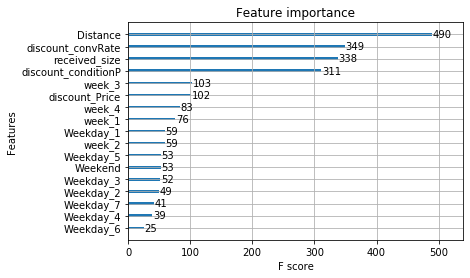

In [299]:
from xgboost import plot_importance
from matplotlib import pyplot
plot_importance(model)
pyplot.show()


## Find suitable threshold for feature selection

In [300]:
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.feature_selection import SelectFromModel
from numpy import sort

In [301]:
# split data into train & valid set
def split_train_valid(row, date_cut="20160416"):
    is_train = True if row < pd.to_datetime(date_cut, format="%Y%m%d") else False
    return is_train

In [360]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(tr4[features], tr4[label], test_size=0.37, random_state=7)

In [309]:
# key error：'weight' when select feature
model = MyXGBClassifier()
# fit model on all training data
model.fit(X_train, y_train)
# make predictions and evaluate
y_pred = model.predict(X_valid)

In [310]:
print("Accuracy: %.2f" % (accuracy_score(y_valid, y_pred)))
print("AUC: %.2f" % ((roc_auc_score(y_true=y_valid, y_score=y_pred)))) # should at least > 0.5
from sklearn.metrics import confusion_matrix
def cm(label,predict):    
    cm=confusion_matrix(label,predict) #row:true; col:predict
    df=pd.DataFrame(cm,columns=np.unique(predict), index = np.unique(label))
    df.index.name = 'Actual'
    df.columns.name = 'Predicted'
    display(df) 
cm(y_valid, y_pred)

Accuracy: 0.95
AUC: 0.95


Predicted,0,1
Actual,,
0,236642,23958
1,3239,257146


In [311]:
# Fit model using each importance as a threshold
thresholds = sort(model.feature_importances_)
for thresh in thresholds:
    # select features using threshold
    selector = SelectFromModel(model, threshold=thresh, prefit=True)
    selected_X_train = selector.transform(X_train)
    # train model
    selection_model = XGBClassifier()
    selection_model.fit(selected_X_train, y_train)
    # evaluate model
    selected_X_valid = selector.transform(X_valid)
    y_pred = selection_model.predict(selected_X_valid)
    accuracy = accuracy_score(y_valid, y_pred)
    AUC=roc_auc_score(y_true=y_valid, y_score=y_pred)
    print("Thresh=%.4f, n=%d, Accuracy: %.2f, AUC=%.2f " % (thresh, selected_X_train.shape[1], accuracy,AUC))

Thresh=0.0000, n=18, Accuracy: 0.95, AUC=0.95 
Thresh=0.0039, n=17, Accuracy: 0.95, AUC=0.95 
Thresh=0.0059, n=16, Accuracy: 0.95, AUC=0.95 
Thresh=0.0072, n=15, Accuracy: 0.95, AUC=0.95 
Thresh=0.0080, n=14, Accuracy: 0.94, AUC=0.94 
Thresh=0.0084, n=13, Accuracy: 0.94, AUC=0.94 
Thresh=0.0097, n=12, Accuracy: 0.94, AUC=0.94 
Thresh=0.0112, n=11, Accuracy: 0.94, AUC=0.94 
Thresh=0.0114, n=10, Accuracy: 0.94, AUC=0.94 
Thresh=0.0131, n=9, Accuracy: 0.92, AUC=0.92 
Thresh=0.0134, n=8, Accuracy: 0.92, AUC=0.92 
Thresh=0.0136, n=7, Accuracy: 0.92, AUC=0.92 
Thresh=0.0140, n=6, Accuracy: 0.91, AUC=0.91 
Thresh=0.0144, n=5, Accuracy: 0.91, AUC=0.91 
Thresh=0.0156, n=4, Accuracy: 0.91, AUC=0.91 
Thresh=0.0185, n=3, Accuracy: 0.91, AUC=0.91 
Thresh=0.0809, n=2, Accuracy: 0.91, AUC=0.91 
Thresh=0.7507, n=1, Accuracy: 0.82, AUC=0.82 


In [361]:
selected_features=['discount_convRate','Distance', 'received_size','discount_conditionP','week_3','discount_Price','week_4']

# MODEL

## Train & Validation

In [362]:
X_train=X_train[selected_features]
X_valid=X_valid[selected_features]

In [363]:
from sklearn.linear_model  import LogisticRegression
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1,0.5, 1,5, 10,50, 100, 1000] }
clf = GridSearchCV(LogisticRegression(),param_grid,cv=10,scoring='roc_auc')
clf.fit(X_train, y_train)
print(clf.best_params_)

{'C': 0.01}


In [364]:
##機率預測
#array [probability as label 0, probability as label 1]
lr=LogisticRegression(C=0.01)
lr.fit(X_train, y_train)
pred_y=np.round(lr.predict_proba(X_valid),3)

##AUC,ACC
auc_score = roc_auc_score(y_true=y_valid, y_score=pred_y[:,1]) 
acc = accuracy_score(y_true=y_valid, y_pred=pred_y.argmax(axis=1))
print("Validation AUC: {:.3f}, Accuracy: {:.3f}".format(auc_score, acc))

Validation AUC: 0.895, Accuracy: 0.849


In [ ]:
# 7 features：Validation AUC: 0.895, Accuracy: 0.850

## Re-Train with whole training set

In [365]:
##用全部訓練集重新建模
train_all_X=tr4[selected_features]
train_all_y=tr4[label]
lr.fit(train_all_X,train_all_y)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Testset

In [366]:
##測試集
ts2 = ts.copy() #避免更改原資料欄
test_X=ts2[selected_features]

In [367]:
test_pred =np.round(lr.predict_proba(test_X),3)

In [369]:
test1 = ts2.copy()
test1['pred_prob']=test_pred[:,1]

In [370]:
#資料輸出設定
output = pd.concat((ts2[["User_id", "Coupon_id", "Date_received"]],test1["pred_prob"]), axis=1)

##合併欄位內容 (joint)：uid
output.loc[:, "User_id"] = output["User_id"].apply(lambda x:str(int(x)))
output.loc[:, "Coupon_id"] = output["Coupon_id"].apply(lambda x:str(int(x)))
output.loc[:, "Date_received"] = output["Date_received"].apply(lambda x:x.strftime("%Y%m%d"))
output["uid"] = output[["User_id", "Coupon_id", "Date_received"]].apply(lambda x: '_'.join(x.values), axis=1)
output.reset_index(drop=True, inplace=True)

##label
out = output.groupby("uid", as_index=False).mean()  
out = out[["uid", "pred_prob"]]
out.columns = ["uid", "label"]
# out.to_csv("baseline_example.csv", header=["uid", "label"], index=False) # submission format
out.head()
len(out)

out.to_csv('submission_logistic.csv',index=False)
check = pd.read_csv('submission_logistic.csv')